<!--NAVIGATION-->
< [**Previous:** 03 - EDA](03-EDA.ipynb) | [**Next:** 05 - Presentation](05-Presentation.ipynb) >   

# Modeling 

The purpose of this notebook is to use a Neural Network model and a Random Forest Classifier Model, and compare the accuracies of both at predicting the types of crimes.

In [48]:
import numpy as np
import pandas as pd
import seaborn as sn
from scipy import optimize as opt
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, normalize
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
%matplotlib inline
import matplotlib.pyplot as plt

In [49]:
dataset = pd.read_csv('/data/anikethb/EDA_dataset.csv')

In [50]:
dataset.head()

,Event Clearance SubGroup,District/Sector,Zone/Beat,Longitude,Latitude,Distance From Center
0,DISTURBANCES,M,M2,-122.338147,47.610975,1.019422
1,THEFT,Q,Q1,-122.404613,47.658325,3.483148
2,"NUISANCE, MISCHIEF COMPLAINTS",M,M2,-122.342843,47.613551,0.744654
3,TRAFFIC RELATED CALLS,D,D1,-122.341847,47.625401,0.527233
4,"NUISANCE, MISCHIEF COMPLAINTS",D,D1,-122.339709,47.627425,0.680518


## Categorical Variables

The column I am predicting contains categorical data, not numerical data, so I have to use Feature Engineering. I am going to need to use one-hot encoding, which will create extra columns that indicate the presence or absence of certain values in 2 of the categorical columns that I will be using(District/Sector, Zone/Beat). For the predictor column, "Event Clearance SubGroup", I will be using LabelEncoding only, which will assign a separate integer value for each unique value in the column. They will be 0-38, as there are 39 unique incidents.

### One-Hot Encoding

In [51]:
str_cols = dataset[['District/Sector', 'Zone/Beat']]
le = LabelEncoder()
target = dataset[['Event Clearance SubGroup']]
str_cols_2 = str_cols.apply(le.fit_transform)
target_2 = target.apply(le.fit_transform)

enc = OneHotEncoder()
enc.fit(str_cols_2)
onehotlabels = enc.transform(str_cols_2).toarray()

In [52]:
cols_encoded = ['Event Clearance SubGroup', 'District/Sector', 'Zone/Beat']
test = pd.DataFrame(onehotlabels)
target_df = pd.DataFrame(target_2)

new_test = pd.concat([dataset.drop(cols_encoded, 1), target_df, test], axis=1).reindex()

# Neural Network Model vs Random Forest Classifier

I will only feed rows that contain one of the top 7 most occurring types of incidents into the models due to the fact that it will take too long to run otherwise, as my dataset has 1.3 million rows.  

In [53]:
#Finding the incidents that occur the most in the dataset
most = new_test.groupby('Event Clearance SubGroup', as_index=False)['Distance From Center'].count()
most.sort_values(['Distance From Center'], ascending=False, inplace=True)
print("Number of Unique Incidents: " + str(len(most)))
most.head()

Number of Unique Incidents: 39


,Event Clearance SubGroup,Distance From Center
34,34,223316
31,31,218507
8,8,188373
20,20,110183
32,32,82928


### Train/Test Split

Using the sorted groupby above, we can find the the most occurring types of incidents and filter the test dataframe according to them.

In [54]:
new_test = new_test[(new_test['Event Clearance SubGroup'] == 34) | (new_test['Event Clearance SubGroup'] == 31) |
                   (new_test['Event Clearance SubGroup'] == 8) | (new_test['Event Clearance SubGroup'] == 20) | 
                    (new_test['Event Clearance SubGroup'] == 14)| (new_test['Event Clearance SubGroup'] == 32) |
                   (new_test['Event Clearance SubGroup'] == 4)]

#I am using more rows for the Random Forest Classification, as it takes less time than the Neural Network model to run
forest_test = new_test[(new_test['Event Clearance SubGroup'] == 34) | (new_test['Event Clearance SubGroup'] == 31) |
                   (new_test['Event Clearance SubGroup'] == 8) | (new_test['Event Clearance SubGroup'] == 20) | 
                    (new_test['Event Clearance SubGroup'] == 14)| (new_test['Event Clearance SubGroup'] == 32) |
                   (new_test['Event Clearance SubGroup'] == 4) | (new_test['Event Clearance SubGroup'] == 35) |
                      (new_test['Event Clearance SubGroup'] == 19)] 

forest_X = forest_test[['Longitude', 'Latitude', 'Distance From Center']]
forest_y = forest_test['Event Clearance SubGroup']
X = new_test[['Longitude', 'Latitude', 'Distance From Center']]
y = new_test['Event Clearance SubGroup']

We need to use train_test_split in order to get the testing and training parts of our data that we input into the models.

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state = 42)
forest_X_train, forest_X_test, forest_y_train, forest_y_test = train_test_split(forest_X, forest_y, test_size=0.33, random_state=42)

## Running the Neural Network Model

In [56]:
#Takes 10 minutes to run
clf = MLPClassifier()
clf.fit(X_train, y_train)
result = clf.predict(X_test)

## Running the Random Forest Classifier Model

In [57]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier()
random_forest.fit(forest_X_train, forest_y_train)
result_forest = random_forest.predict(forest_X_test)

# Results(Accuracy)

### Accuracy Scores

Now, we need to check the accuracy of our two model

#### Neural Network Accuracy

In [58]:
print(accuracy_score(y_test, result))

0.2603846251620612


#### Random Forest Classifier Accuracy

In [59]:
print(accuracy_score(y_test, result_forest))

0.43636080534865396


As seen by the output above, the accuracy of the Neural Network model is around 25.4%. The reason why the accuracy is this low is due to the fact that I am only testing using rows that have the top 7 most occurring incidents. However, the model works better than randomly picking 1 of the 7 categories, as there is a $\frac{1}{7}$ (14.28%) chance of predicting the right one.

The accuracy of the Random Forest Classifier is around 43.7%, which is a lot better than the Neural Network Model's for the data that I have.

## Confusion Matrices

In [60]:
from sklearn.metrics import confusion_matrix

matrix = confusion_matrix(y_test, result)
forest_matrix = confusion_matrix(forest_y_test, result_forest)

### Neural Network Model Confusion Matrix

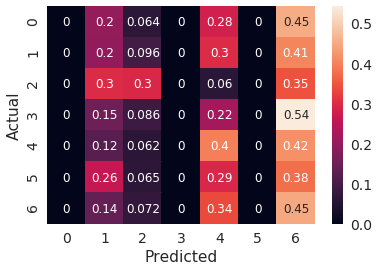

In [61]:
cm = normalize(matrix, axis=1, norm='l1')
df_cm = pd.DataFrame(cm, range(len(cm)), range(len(cm)))

sn.set(font_scale=1.4)
h_map = sn.heatmap(df_cm, annot=True,annot_kws={"size": 12}); #font size
plt.ylabel('Actual')
plt.xlabel('Predicted');

### Random Forest Model Confusion Matrix

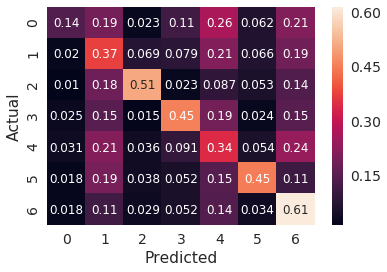

In [62]:
forest_cm = normalize(forest_matrix, axis=1, norm='l1')
df_cm = pd.DataFrame(forest_cm, range(len(forest_cm)), range(len(forest_cm)))

sn.set(font_scale=1.4)
h_map = sn.heatmap(df_cm, annot=True,annot_kws={"size": 12}); #font size
plt.ylabel('Actual')
plt.xlabel('Predicted');

## Through these confusion matrices and accuracy scores, it is clear that the Random Forest Classifier model did a better job of predicting the type of crime based on several factors related to their locations. We can conclude that location does play a factor in the type of crime that takes place, but is not the only factor, as the models from my data only predict accurately 25% and 43% of the time respectively.

<!--NAVIGATION-->
< [**Previous:** 03 - EDA](03-EDA.ipynb) | [**Next:** 05 - Presentation](05-Presentation.ipynb) >    